In [ ]:
pip install statsmodels --upgrade

In [ ]:
#mount to google drive to access tests and data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/COVID

/content/drive/MyDrive/COVID


In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import concat

In [ ]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

In [ ]:
cases.head(3)

## Data Clean-up

In [ ]:
cases = cases.fillna(0)
vaccinations = vaccinations.fillna(0)
counties = counties.fillna(0)
mask_use = mask_use.fillna(0)

In [ ]:
counties['FIPS'] = (counties['STATE'] * 1000) + counties['COUNTY']

In [ ]:
county_data = county_data = cases.merge(counties, how='inner', on='FIPS').merge(mask_use, how='inner', right_on='COUNTYFP', left_on='FIPS')

# **Hypothesis 1**

## Baseline: Persistence Model (daily counts)

The simplest model that we could use to make predictions would be to persist the last observation (persistence model) and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

In [ ]:
cases_dates_only = cases.groupby('Province_State').agg('sum').iloc[:,11:].reset_index()
cases_dates_only = cases_dates_only.set_index('Province_State').T
cases_dates_only.index = pd.to_datetime(cases_dates_only.index)
cases_dates_only.index = pd.DatetimeIndex(cases_dates_only.index).to_period('D')
cases_dates_only

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-01-28,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-01-29,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-01-30,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-01-31,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-02-01,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,732151,93632,0,1037012,467496,4445862,630799,377682,122956,49,56694,3352451,1468410,103,11819,69144,229597,1554336,889362,417152,383795,609924,705498,78803,505557,772742,1081179,663248,455282,781592,131752,250264,399234,110256,1108291,238430,2313361,1267333,120602,249,1268841,572223,291978,1329111,175068,164725,776342,135538,1115345,3768545,475625,29436,6102,793396,590281,201660,749099,79297
2021-09-09,736518,94474,0,1039492,469977,4451347,632699,378308,123308,49,56859,3352451,1475996,103,12034,69573,231056,1559077,894516,417152,383830,615168,710401,79423,506464,775149,1081179,664459,458420,784110,132750,251219,400349,110779,1110501,239006,2319680,1273623,121217,249,1276738,574685,294392,1333308,175766,165454,779898,136157,1119545,3793204,477790,29588,6182,797348,594344,203403,751195,79830
2021-09-10,741318,95175,0,1042480,472136,4462876,634888,378933,123958,49,56966,3452700,1484274,103,12227,70320,232630,1564386,899844,417152,388019,620356,712574,79929,508017,777022,1088201,666496,460312,787268,133715,252159,401901,111111,1113165,239886,2325332,1279500,121849,250,1285757,577312,296825,1338313,176234,165849,784052,136772,1124713,3812711,479979,29735,6182,801827,597732,205783,753972,80643
2021-09-11,745812,95175,0,1045835,473885,4468594,634888,378933,124575,49,56966,3452700,1484274,103,12294,71156,233577,1564386,899844,417152,388019,620356,712574,80513,509393,777022,1088201,666496,460312,790011,133715,253080,401901,111111,1115659,239886,2331615,1279500,122351,250,1294162,577312,296825,1342953,176693,165849,784052,136772,1124713,3821518,479979,29934,6250,801827,597732,208045,753972,80643


Test MSE: 137935124.929


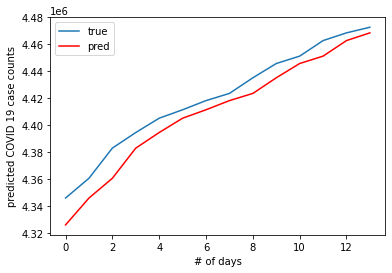

In [ ]:
series = cases_dates_only['California']

#create lagged dataset
values = pd.DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

#split to train and test
X = dataframe.values
train, test = X[1:len(X)-14], X[len(X)-14:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
#persist last value
predictions = list()
for x in test_X:
	yhat = x
	predictions.append(yhat)

test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

#plot predictions vs expected
plt.plot(test_y, label='true')
plt.plot(predictions, color='red', label='pred')
plt.xlabel('# of days')
plt.ylabel('predicted COVID 19 case counts')
plt.legend()
plt.show()

## Univariate Autoregressive Modeling

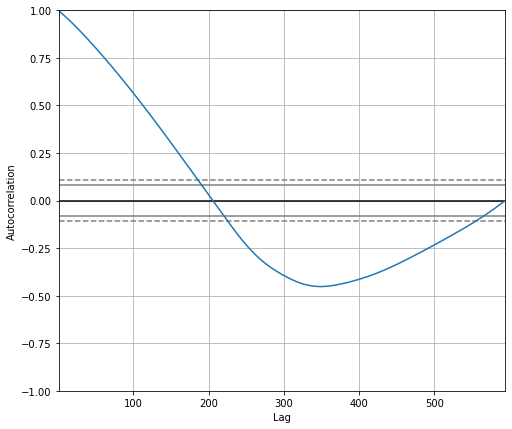

In [ ]:
#Visualize the autocorrelation
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=[8,7])
autocorrelation_plot(cases_dates_only['California'])
plt.show()

In [ ]:
#Predicting 1 day

state = 'California'

X = cases_dates_only[state]
train, test = X[:len(X)-1], X[len(X)-1:]

model = AutoReg(train, lags=4)
model = model.fit()

predictions = model.predict(start=len(train), end=len(X)-1, dynamic=False)

rmse = sqrt(mean_squared_error(test.values, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3169.987


predicted=4336783.004923, expected=4346129.000000
predicted=4345934.809894, expected=4360789.000000
predicted=4354863.238618, expected=4383152.000000
predicted=4364208.099292, expected=4394711.000000
predicted=4373193.884969, expected=4405324.000000
predicted=4382098.529638, expected=4411570.000000
predicted=4390998.098752, expected=4418368.000000
predicted=4399759.131130, expected=4423696.000000
predicted=4408441.661502, expected=4435277.000000
predicted=4417052.627813, expected=4445862.000000
predicted=4425570.365110, expected=4451347.000000
predicted=4434007.711344, expected=4462876.000000
predicted=4442365.243716, expected=4468594.000000
predicted=4450640.151032, expected=4472759.000000
Test RMSE: 26031.289


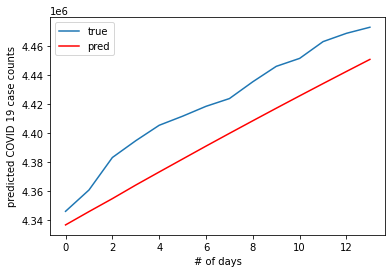

In [ ]:
#Predicting 14 days

state = 'California'

X = cases_dates_only[state]
train, test = X[:len(X)-14], X[len(X)-14:]

model = AutoReg(train, lags=4)
model = model.fit()

predictions = model.predict(start=len(train), end=len(X)-1, dynamic=False)

for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = sqrt(mean_squared_error(test.values, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test.values, label='true')
plt.plot(predictions.values, color='red', label='pred')
plt.xlabel('# of days')
plt.ylabel('predicted COVID 19 case counts')
plt.legend()
plt.show()

## Improving the model the Univariate Autoregression Model

optimal lag:  52


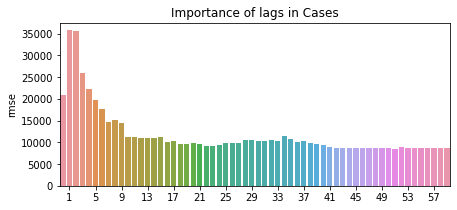

In [ ]:
col = 'Cases'
#Lag importance
X = cases_dates_only['California'].values
train, test = X[1:len(X)-14], X[len(X)-14:]

lag_df = {i:0 for i in range(1, 61)}

for lag in range(1, 61):
 model = AutoReg(train, lags=lag)
 model = model.fit()
 predict = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
 rmse = sqrt(mean_squared_error(test, predict))
 lag_df[lag] = rmse

lag_df = pd.DataFrame.from_dict(lag_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of lags in %s' % (col))
sns.barplot(data=lag_df, x=lag_df.index, y='rmse')
plt.xticks(ticks=[i for i in range(1,61,4)], labels=[i for i in range(1,61,4)])
print('optimal lag: ', lag_df['rmse'].idxmin())
plt.show()

In [ ]:
#split dataset
X = cases_dates_only['California'].values
train, test = X[1:len(X)-14], X[len(X)-14:]

#train autoregression
window = 52
model = AutoReg(train, lags=52)
model_fit = model.fit()
coef = model_fit.params

history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))

print('Test RMSE: %.3f' % rmse)

plt.plot(test, label='true')
plt.plot(predictions, color='red', label='pred')
plt.xlabel('# of days')
plt.ylabel('predicted COVID 19 case counts')
plt.legend()
plt.show()

## CV on Univariate Autoregression Model

In [ ]:
X = cases_dates_only['California'].values

# 14 days of testing
# 15 days  of validation

train, val = X[:len(X)-15], X[len(X)-15:]
train, test = train[:len(train)-14], train[len(train)-14:]

predicted=4137489.207251, expected=4132332.000000
predicted=4145898.130836, expected=4148367.000000
predicted=4161348.497928, expected=4163848.000000
predicted=4174635.128370, expected=4176356.000000
predicted=4193470.415167, expected=4188640.000000
predicted=4201950.461836, expected=4214548.000000
predicted=4227177.049681, expected=4227429.000000
predicted=4242833.529839, expected=4234699.000000
predicted=4251445.092546, expected=4251704.000000
predicted=4265134.495365, expected=4266957.000000
predicted=4279478.554733, expected=4280215.000000
predicted=4300165.703634, expected=4293363.000000
predicted=4308139.440076, expected=4309137.000000
predicted=4321665.056911, expected=4318553.000000
Test RMSE: 5007.520


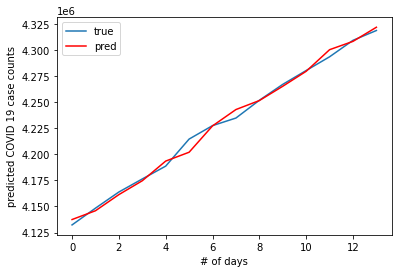

In [ ]:
#train autoregression
window = 52
model = AutoReg(train, lags=52)
model_fit = model.fit()
coef = model_fit.params

history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

#predict on test
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))

print('Test RMSE: %.3f' % rmse)

plt.plot(test, label='true')
plt.plot(predictions, color='red', label='pred')
plt.xlabel('# of days')
plt.ylabel('predicted COVID 19 case counts')
plt.legend()
plt.show()

predicted=4137489.207251, expected=4326204.000000
predicted=4384316.245344, expected=4346129.000000
predicted=4416193.888264, expected=4360789.000000
predicted=4397560.545875, expected=4383152.000000
predicted=4415103.996002, expected=4394711.000000
predicted=4443242.135278, expected=4405324.000000
predicted=4454699.581892, expected=4411570.000000
predicted=4460358.888935, expected=4418368.000000
predicted=4423237.115978, expected=4423696.000000
predicted=4377486.163480, expected=4435277.000000
predicted=4479616.444369, expected=4445862.000000
predicted=4471056.848256, expected=4451347.000000
predicted=4431190.435539, expected=4462876.000000
predicted=4464438.800331, expected=4468594.000000
predicted=4479843.834076, expected=4472759.000000
Validation RMSE: 58745.308


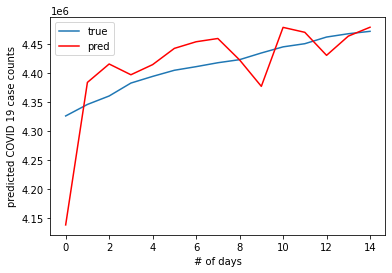

In [ ]:
#predict on val

history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(val)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = val[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(val, predictions))

print('Validation RMSE: %.3f' % rmse)

plt.plot(val, label='true')
plt.plot(predictions, color='red', label='pred')
plt.xlabel('# of days')
plt.ylabel('predicted COVID 19 case counts')
plt.legend()
plt.show()

# **Hypothesis 2**

##Multivariate Autoregression

In [ ]:
cases_dates_only = cases.groupby('Province_State').agg('sum').iloc[:,11:].reset_index()
cases_dates_only.head(5)

,Province_State,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,...,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21,8/9/21,8/10/21,8/11/21,8/12/21,8/13/21,8/14/21,8/15/21,8/16/21,8/17/21,8/18/21,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,595816,599633,603318,607209,607209,612086,615901,619752,623919,627905,627905,634897,637363,641386,645851,649741,653540,659750,663065,665653,665653,665653,676795,681828,688018,691451,694523,699729,704420,709732,714860,719280,722122,724688,727360,732151,736518,741318,745812,747606
1,Alaska,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,76874,77253,77586,77586,77586,78441,78701,78701,79485,79823,79823,79823,80885,81337,82002,82687,83156,83156,83156,84272,84867,85491,86218,86753,86753,86753,87908,88547,89345,90060,90642,90642,90642,90642,92790,93632,94474,95175,95175,95175
2,American Samoa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arizona,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,...,935647,937936,940762,943415,946054,948245,950827,952797,955767,958992,962410,965462,967862,970523,972925,976471,979580,982775,986082,988714,991309,991309,998164,1001871,1005764,1007854,1011101,1011923,1016663,1020133,1023935,1027359,1030430,1032808,1034790,1037012,1039492,1042480,1045835,1048600
4,Arkansas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,394461,397238,400275,402908,404277,405272,407892,410832,413150,416173,418290,419807,420663,422866,425551,429100,431507,434027,435256,436242,438465,441246,443564,446430,448596,449383,450265,452891,455781,458234,460363,462723,463795,464732,465315,467496,469977,472136,473885,475001


In [ ]:
pct_change_day = cases_dates_only.set_index('Province_State').T
pct_change_day = pct_change_day.pct_change()
pct_change_day = pct_change_day.fillna(0)
pct_change_day.index = pd.to_datetime(pct_change_day.index)
pct_change_day.index = pd.DatetimeIndex(pct_change_day.index).to_period('D')
pct_change_day.head(5)

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-31,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#calculate the percent change for vaccinations
vaccinations = vaccinations.sort_values('Date', ascending=True)
pct_change_dfs = []
for state in pct_change_day.columns:
  sub_df = vaccinations.loc[vaccinations['Province_State'] == state]
  sub_df.iloc[:,-2:] = sub_df.iloc[:,-2:].pct_change(axis=0)
  sub_df.replace([np.inf, -np.inf], np.nan, inplace=True)
  sub_df = sub_df.fillna(0)
  pct_change_dfs.append(sub_df)

vax_pct_change = pd.concat(pct_change_dfs, axis=0)

In [ ]:
datetime = pd.to_datetime(cases_dates_only.set_index('Province_State').columns).to_period('D')
dates = [str(i) for i in datetime if str(i) >= '2020-12-10' and str(i) <= '2021-09-12']

In [ ]:
vax_cases = pd.DataFrame(columns=['Date', 'Cases', 'Full_Vaccinations', 'Partial_Vaccinations'])

case = []
par_vax = []
full_vax = []

for day in range(len(dates)):
  date = dates[day]
  state = 'California'
  case.append(pct_change_day.loc[date][state])
  par_vax.append(float(vax_pct_change.loc[(vax_pct_change['Date'] == date) & (vax_pct_change['Province_State'] == state)]['People_Partially_Vaccinated']))
  full_vax.append(float(vax_pct_change.loc[(vax_pct_change['Date'] == date) & (vax_pct_change['Province_State'] == state)]['People_Fully_Vaccinated']))

vax_cases['Date'] = dates
vax_cases['Cases'] = case
vax_cases['Full_Vaccinations'] = full_vax
vax_cases['Partial_Vaccinations'] = par_vax

vax_cases = vax_cases.set_index('Date')

In [ ]:
vax_cases.describe()

,Cases,Full_Vaccinations,Partial_Vaccinations
count,277.000000,277.000000,277.000000
mean,0.004037,0.012372,0.002015
std,0.006478,0.020407,0.008889
min,-0.000366,-0.003164,-0.022489
25%,0.000466,0.000000,-0.000457
50%,0.001239,0.002786,0.000000
75%,0.003588,0.016550,0.004097
max,0.037095,0.131143,0.037258


***Why implement a multivariate autoregressive model?***

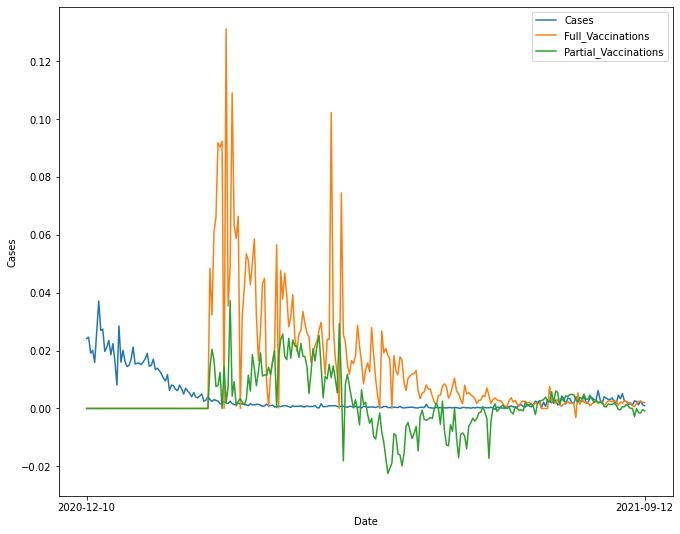

In [ ]:
plt.figure(figsize=(11,9))
for col in vax_cases.columns:
  sns.lineplot(data=vax_cases, x=vax_cases.index, y=col, label=col)
  plt.xticks([dates[0], dates[-1]])

We can see the continued decline in increase in cases as vaccinations roll out.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=30
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

causation = grangers_causation_matrix(vax_cases, variables = vax_cases.columns)

In [ ]:
causation

,Cases_x,Full_Vaccinations_x,Partial_Vaccinations_x
Cases_y,1.0000,0.4013,0.8423
Full_Vaccinations_y,0.0096,1.0000,0.0000
Partial_Vaccinations_y,0.6969,0.0000,1.0000


Causality Analysis:

Cases is causing Full_Vaccinations (p_value = 0.0096 < 0.05), Full_Vaccinations is causing Partial Vaccinations (p_value = 0.00 < 0.05) and Partial_Vaccinations is causing Full_Vaccinations (p_value = 0.0 < 0.05). Because our features cause each other, this makes this system of multi time series a good candidate for using VAR models.

Baseline Model for VAR

In [ ]:
#Predicting 1 day
#creating the train and validation set

# split dataset
X = vax_cases
train, test = X[:len(X)-1], X[len(X)-1:]

model = VAR(endog=train)
model_fit = model.fit(maxlags=60)

# make prediction on validation
prediction = model_fit.forecast(model.y, steps=len(test))
prediction = pd.DataFrame(prediction, columns=test.columns)

#Cases
rmse = sqrt(mean_squared_error(test['Cases'], prediction['Cases']))
print('Test RMSE (Cases): %.3f' % rmse)

#Full_Vaccinations
rmse = sqrt(mean_squared_error(test['Full_Vaccinations'], prediction['Full_Vaccinations']))
print('Test RMSE (Cases): %.3f' % rmse)

#Partial_Vaccinations
rmse = sqrt(mean_squared_error(test['Partial_Vaccinations'], prediction['Partial_Vaccinations']))
print('Test RMSE (Partial_Vaccinations): %.3f' % rmse)

Test RMSE (Cases): 0.000
Test RMSE (Cases): 0.011
Test RMSE (Partial_Vaccinations): 0.010


Test RMSE: 0.003


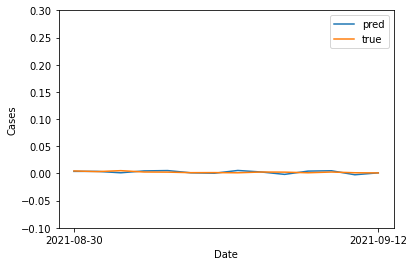

Test RMSE: 0.011


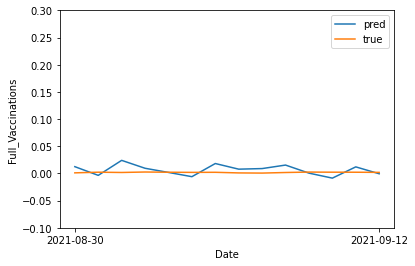

Test RMSE: 0.020


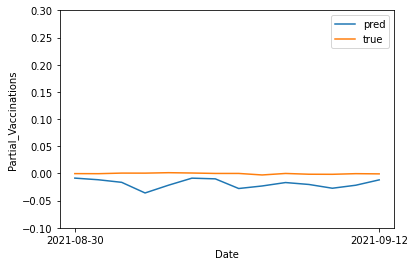

In [ ]:
#Predicting 14 days
#creating the train and validation set

# split dataset
X = vax_cases
train, test = X[:len(X)-14], X[len(X)-14:]

model = VAR(endog=train)
model_fit = model.fit(maxlags=60)

# make prediction on validation
prediction = model_fit.forecast(model.y, steps=len(test))
prediction = pd.DataFrame(prediction, columns=test.columns)

#Cases
col='Cases'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Full_Vaccinations
col='Full_Vaccinations'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Partial_Vaccinations
col='Partial_Vaccinations'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

## Improving the Multivariate Autoregression Model :)

optimal lag:  8


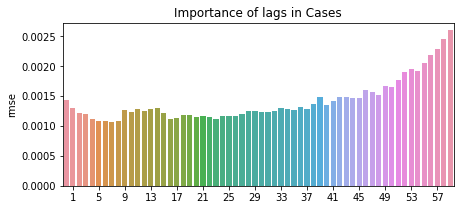

optimal lag:  27


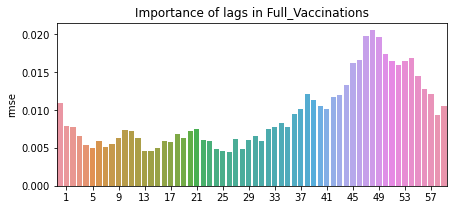

optimal lag:  27


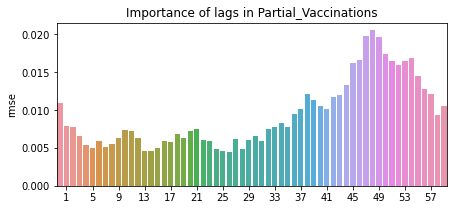

In [ ]:
#Importance of lags: Cases
# split dataset
X = vax_cases
train, test = X[:len(X)-14], X[len(X)-14:]

lag_df = {i:0 for i in range(1, 61)}

col = 'Cases'
for lag in range(1, 61):
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=lag)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  lag_df[lag] = rmse

lag_df = pd.DataFrame.from_dict(lag_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of lags in %s' % (col))
sns.barplot(data=lag_df, x=lag_df.index, y='rmse')
plt.xticks(ticks=[i for i in range(1,61,4)], labels=[i for i in range(1,61,4)])
optim1=lag_df['rmse'].idxmin()
print('optimal lag: ', optim1)
plt.show()

col = 'Full_Vaccinations'
lag_df = {i:0 for i in range(1, 61)}

for lag in range(1, 61):
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=lag)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  lag_df[lag] = rmse

lag_df = pd.DataFrame.from_dict(lag_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of lags in %s' % (col))
sns.barplot(data=lag_df, x=lag_df.index, y='rmse')
plt.xticks(ticks=[i for i in range(1,61,4)], labels=[i for i in range(1,61,4)])
optim2=lag_df['rmse'].idxmin()
print('optimal lag: ', optim2)
plt.show()

col = 'Full_Vaccinations'
lag_df = {i:0 for i in range(1, 61)}

for lag in range(1, 61):
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=lag)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  lag_df[lag] = rmse

col = 'Partial_Vaccinations'
lag_df = pd.DataFrame.from_dict(lag_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of lags in %s' % (col))
sns.barplot(data=lag_df, x=lag_df.index, y='rmse')
plt.xticks(ticks=[i for i in range(1,61,4)], labels=[i for i in range(1,61,4)])
optim3=lag_df['rmse'].idxmin()
print('optimal lag: ', optim3)
plt.show()

optimal lag is average optimal lag between all three features

In [ ]:
optim_lag = int(np.mean([optim1, optim2, optim3]))

optimal ic:  hqic


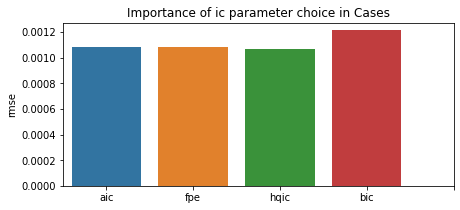

optimal ic:  hqic


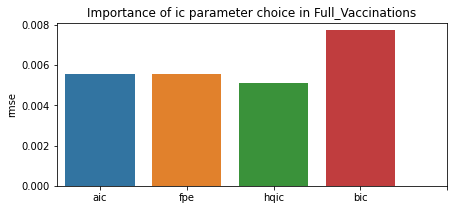

optimal ic:  None


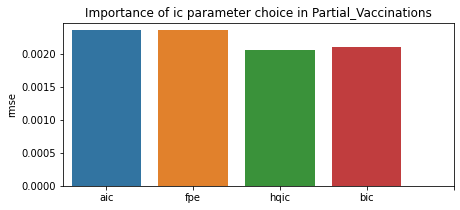

In [ ]:
#Importance of information criterion
# split dataset
X = vax_cases
train, test = X[:len(X)-14], X[len(X)-14:]

ic_list = ['aic', 'fpe', 'hqic', 'bic', None]
ic_df = {i:0 for i in ic_list}

col = 'Cases'
for i in ic_list:
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=optim_lag, ic=i)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  ic_df[i] = rmse

ic_df = pd.DataFrame.from_dict(ic_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of ic parameter choice in %s' % (col))
sns.barplot(data=ic_df, x=ic_df.index, y='rmse')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=ic_list)
print('optimal ic: ', ic_df['rmse'].idxmin())
plt.show()

col = 'Full_Vaccinations'
ic_df = {i:0 for i in ic_list}

for i in ic_list:
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=optim_lag, ic=i)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  ic_df[i] = rmse

ic_df = pd.DataFrame.from_dict(ic_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of ic parameter choice in %s' % (col))
sns.barplot(data=ic_df, x=ic_df.index, y='rmse')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=ic_list)
print('optimal ic: ', ic_df['rmse'].idxmin())
plt.show()

col = 'Partial_Vaccinations'
ic_df = {i:0 for i in ic_list}

for i in ic_list:
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=optim_lag, ic=i)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  ic_df[i] = rmse

ic_df = pd.DataFrame.from_dict(ic_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of ic parameter choice in %s' % (col))
sns.barplot(data=ic_df, x=ic_df.index, y='rmse')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=ic_list)
print('optimal ic: ', ic_df['rmse'].idxmin())
plt.show()


optimal trend parameter:  n


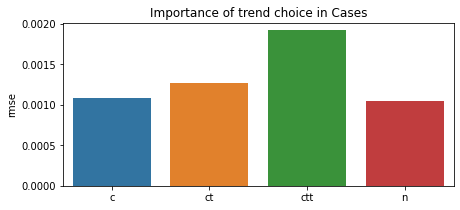

optimal trend parameter:  n


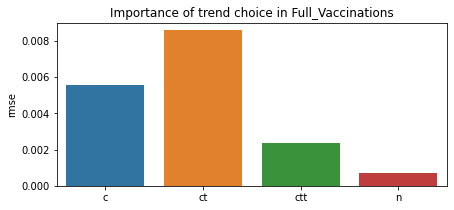

optimal trend parameter:  ct


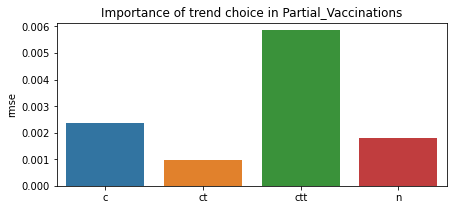

In [ ]:
#Importance of trend
# split dataset
X = vax_cases
train, test = X[:len(X)-14], X[len(X)-14:]

trend_list = ['c', 'ct', 'ctt', 'n']
trend_df = {i:0 for i in trend_list}

col = 'Cases'
for t in trend_list:
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=optim_lag, ic='aic', trend=t)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  trend_df[t] = rmse

trend_df = pd.DataFrame.from_dict(trend_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of trend choice in %s' % (col))
sns.barplot(data=trend_df, x=trend_df.index, y='rmse')
plt.xticks(ticks=[0, 1, 2, 3], labels=trend_list)
print('optimal trend parameter: ', trend_df['rmse'].idxmin())
plt.show()

col = 'Full_Vaccinations'
trend_df = {i:0 for i in trend_list}

for t in trend_list:
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=optim_lag, ic='aic', trend=t)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  trend_df[t] = rmse

trend_df = pd.DataFrame.from_dict(trend_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of trend choice in %s' % (col))
sns.barplot(data=trend_df, x=trend_df.index, y='rmse')
plt.xticks(ticks=[0, 1, 2, 3], labels=trend_list)
print('optimal trend parameter: ', trend_df['rmse'].idxmin())
plt.show()

col = 'Partial_Vaccinations'
trend_df = {i:0 for i in trend_list}

for t in trend_list:
  model = VAR(endog=train)
  model_fit = model.fit(maxlags=optim_lag, ic='aic', trend=t)
  prediction = model_fit.forecast(model.y, steps=len(test))
  prediction = pd.DataFrame(prediction, columns=test.columns)

  rmse = sqrt(mean_squared_error(test[col], prediction[col]))
  trend_df[t] = rmse

trend_df = pd.DataFrame.from_dict(trend_df, orient='index', columns=['rmse'])

plt.figure(figsize=[7, 3])
plt.title('Importance of trend choice in %s' % (col))
sns.barplot(data=trend_df, x=trend_df.index, y='rmse')
plt.xticks(ticks=[0, 1, 2, 3], labels=trend_list)
print('optimal trend parameter: ', trend_df['rmse'].idxmin())
plt.show()

optimal trend parameter is 'n'

**Final Multivariate Autoregression Model!!!**

Test RMSE: 0.001


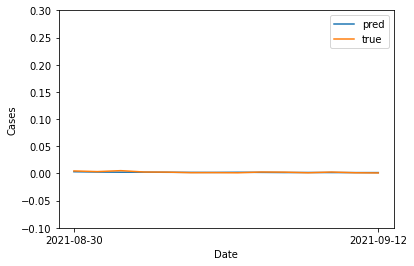

Test RMSE: 0.001


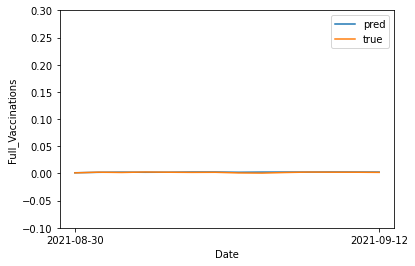

Test RMSE: 0.002


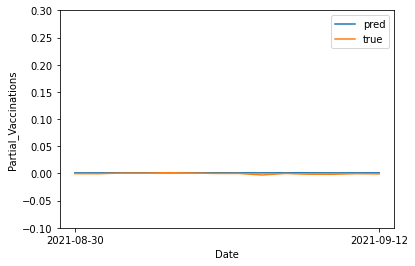

In [ ]:
X = vax_cases
train, test = X[:len(X)-14], X[len(X)-14:]

model = VAR(endog=train)
model_fit = model.fit(maxlags=optim_lag, ic='aic', trend='n')

# make prediction on test
prediction = model_fit.forecast(model.y, steps=len(test))
prediction = pd.DataFrame(prediction, columns=test.columns)

#Cases
col='Cases'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Full_Vaccinations
col='Full_Vaccinations'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Partial_Vaccinations
col='Partial_Vaccinations'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

## CV on Multivariate Regression Model

In [ ]:
X = vax_cases

# 14 days of testing
# 15 days  of validation

train, val = X[:len(X)-15], X[len(X)-15:]
train, test = train[:len(train)-14], train[len(train)-14:]

Test RMSE: 0.002


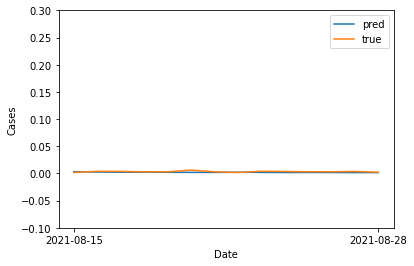

Test RMSE: 0.001


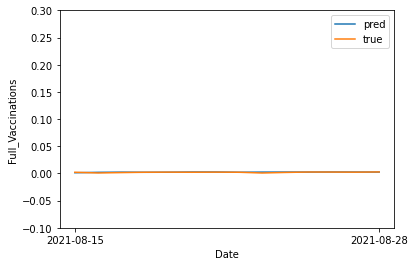

Test RMSE: 0.001


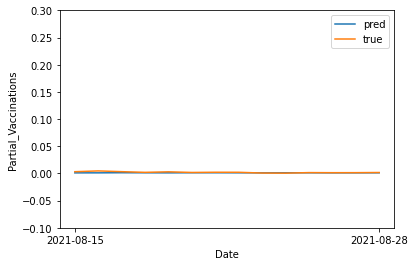

In [ ]:
# make prediction on test set
prediction = model_fit.forecast(model.y, steps=len(test))
prediction = pd.DataFrame(prediction, columns=test.columns)

#Cases
col='Cases'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Full_Vaccinations
col='Full_Vaccinations'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Partial_Vaccinations
col='Partial_Vaccinations'
sns.lineplot(data=prediction, x=test.index, y=col, label='pred')
sns.lineplot(data=test, x=test.index, y=col, label='true')
plt.xticks([test.index[0], test.index[-1]])
rmse = sqrt(mean_squared_error(test[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

Test RMSE: 0.001


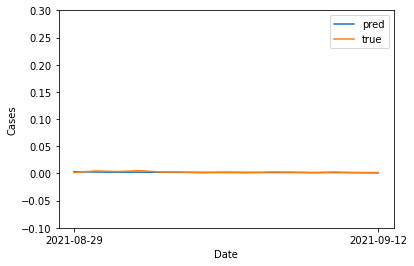

Test RMSE: 0.001


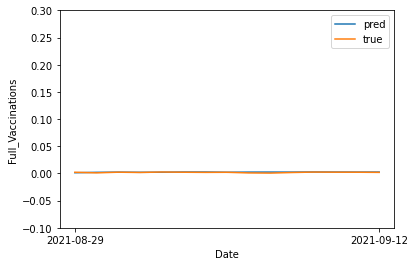

Test RMSE: 0.002


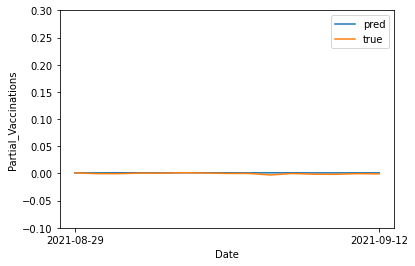

In [ ]:
# make prediction on validation set
prediction = model_fit.forecast(model.y, steps=len(val))
prediction = pd.DataFrame(prediction, columns=val.columns)

#Cases
col='Cases'
sns.lineplot(data=prediction, x=val.index, y=col, label='pred')
sns.lineplot(data=val, x=val.index, y=col, label='true')
plt.xticks([val.index[0], val.index[-1]])
rmse = sqrt(mean_squared_error(val[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Full_Vaccinations
col='Full_Vaccinations'
sns.lineplot(data=prediction, x=val.index, y=col, label='pred')
sns.lineplot(data=val, x=val.index, y=col, label='true')
plt.xticks([val.index[0], val.index[-1]])
rmse = sqrt(mean_squared_error(val[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()

#Partial_Vaccinations
col='Partial_Vaccinations'
sns.lineplot(data=prediction, x=val.index, y=col, label='pred')
sns.lineplot(data=val, x=val.index, y=col, label='true')
plt.xticks([val.index[0], val.index[-1]])
rmse = sqrt(mean_squared_error(val[col], prediction[col]))
print('Test RMSE: %.3f' % rmse)

plt.ylim(-0.1,.3)
plt.show()